In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3a
commitnumber = 1996322
conc = 0.0008
dv = 0.01
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0]
ng_refs = [3, 2, 4]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.65, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

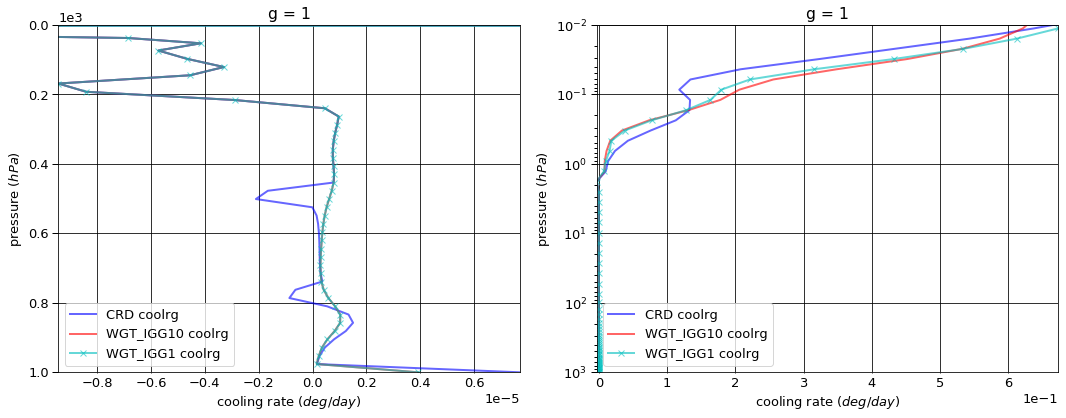

# Figure: cooling rate g-group 2

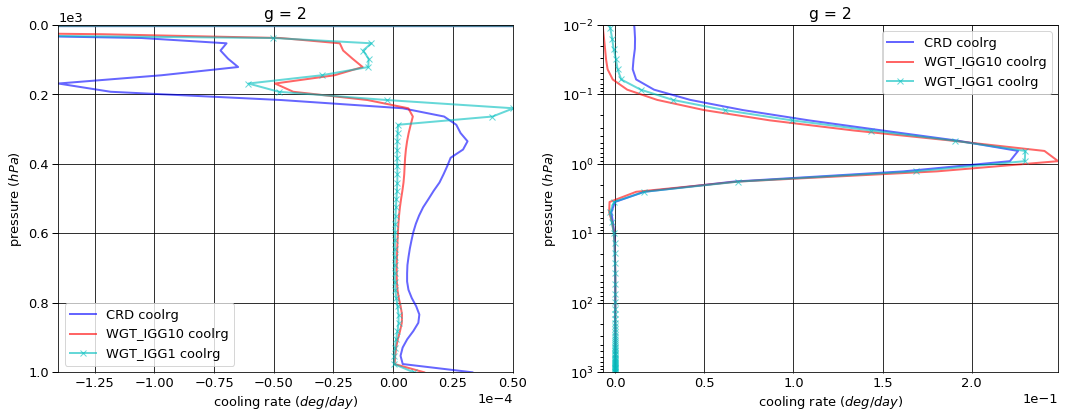

# Figure: cooling rate g-group 3

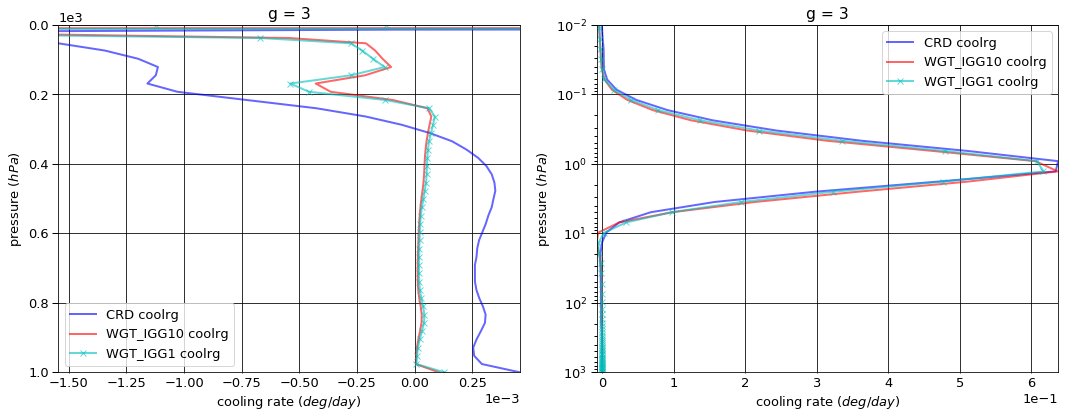

# Figure: cooling rate g-group 4

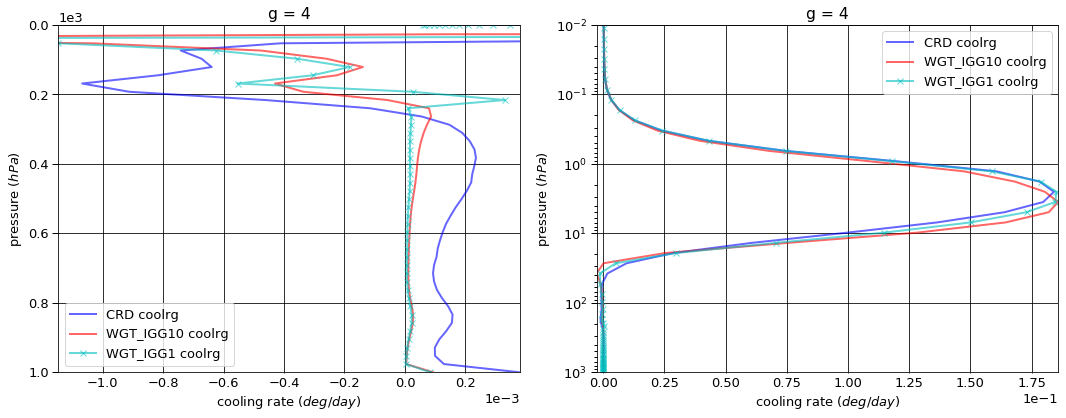

# Figure: cooling rate g-group 5

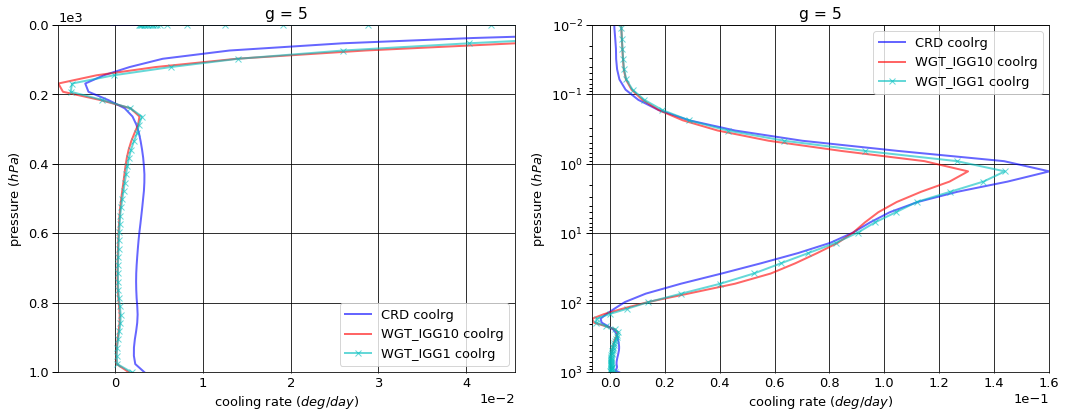

# Figure: cooling rate g-group 6

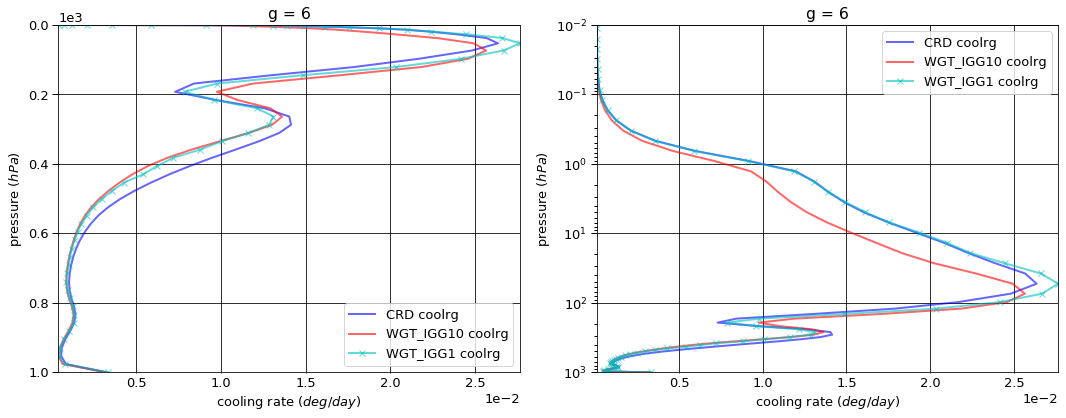

# Figure: cooling rate g-group 7

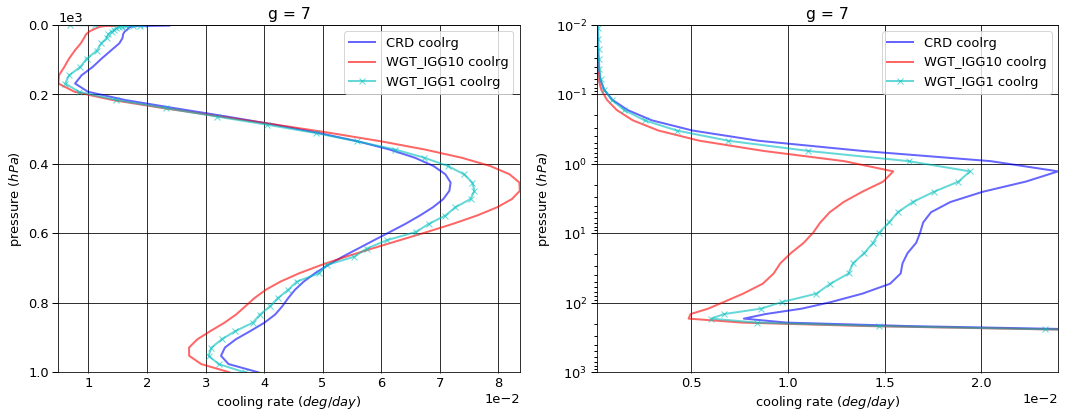

# Figure: cooling rate g-group 8

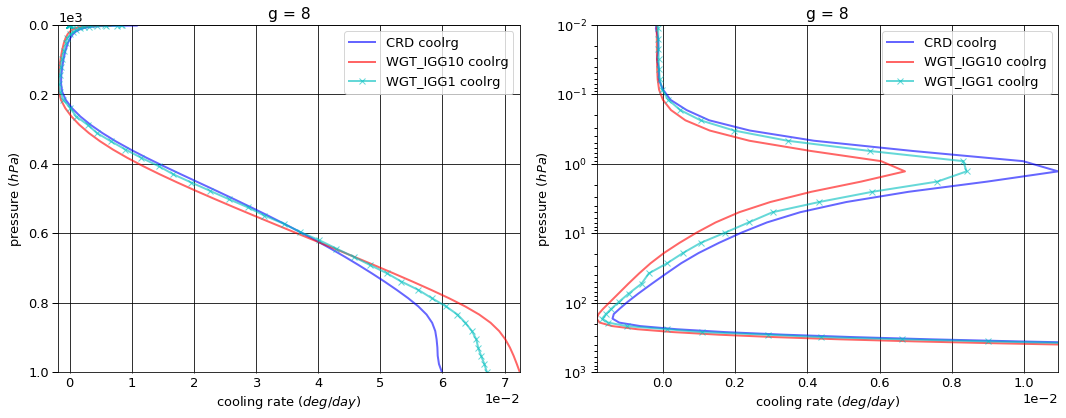

# Figure: cooling rate g-group 9

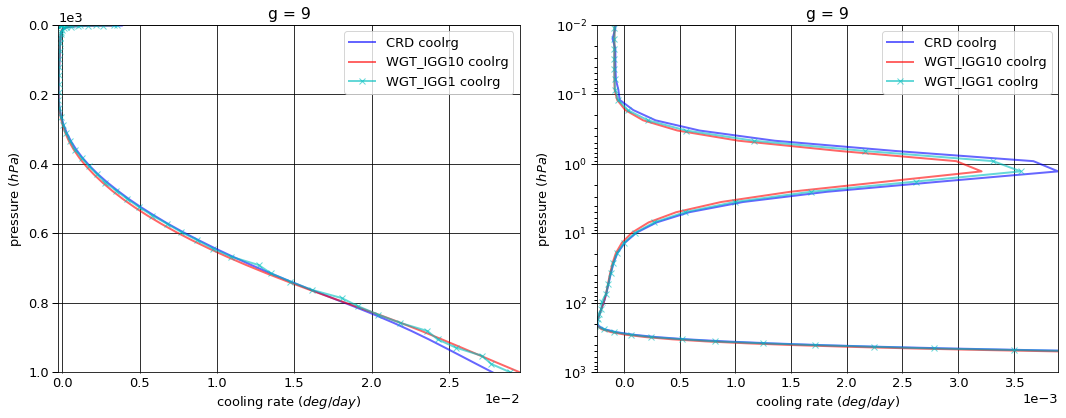

# Figure: cooling rate g-group total

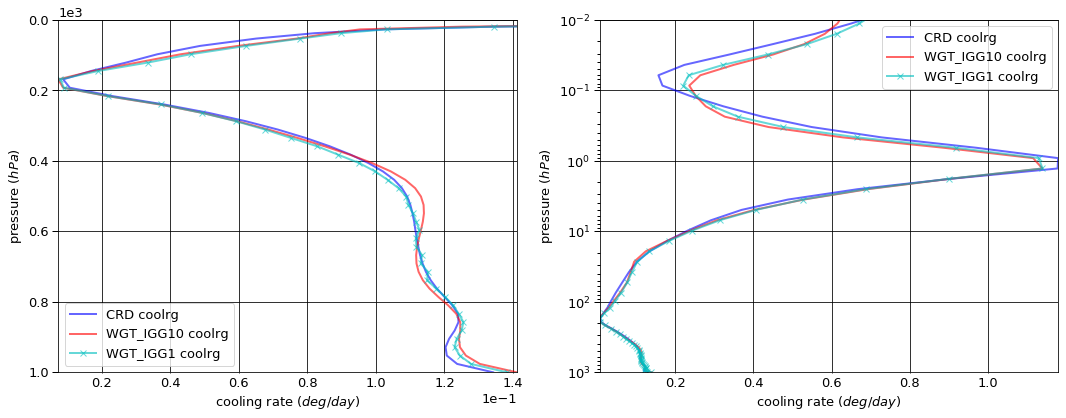

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008934  0.000000  -0.008934
  1013.0   76     -0.022579  0.022557  -0.000022
2 0.0      1      -0.033583  0.000000  -0.033583
  1013.0   76     -0.049695  0.049596  -0.000099
3 0.0      1      -0.185596  0.000000  -0.185596
  1013.0   76     -0.284882  0.278815  -0.006067
4 0.0      1      -0.248532  0.000000  -0.248532
  1013.0   76     -0.487985  0.486227  -0.001758
5 0.0      1      -0.767073  0.000000  -0.767073
  1013.0   76     -1.696290  1.616319  -0.079971
6 0.0      1      -0.887904  0.000000  -0.887904
  1013.0   76     -2.319760  2.308611  -0.011149
7 0.0      1      -5.578056  0.000000  -5.578056
  1013.0   76     -9.723756  9.243982  -0.479774
8 0.0      1      -7.094676  0.000000  -7.094676
  1013.0   76     -8.249624  4.473583  -3.776042
9 0.0      1     -13.192465  0.000000 -13.192465
  1013.0   76    -13.400837  1.215827 -12.185009


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008076  0.000000  -0.008076
  1013.0   76     -0.022579  0.022568  -0.000011
2 0.0      1      -0.034365  0.000000  -0.034365
  1013.0   76     -0.049695  0.049659  -0.000036
3 0.0      1      -0.192170  0.000000  -0.192170
  1013.0   76     -0.284882  0.284592  -0.000290
4 0.0      1      -0.253992  0.000000  -0.253992
  1013.0   76     -0.487985  0.487727  -0.000258
5 0.0      1      -0.655802  0.000000  -0.655802
  1013.0   76     -1.696290  1.691821  -0.004469
6 0.0      1      -0.847559  0.000000  -0.847559
  1013.0   76     -2.319760  2.309621  -0.010139
7 0.0      1      -5.394381  0.000000  -5.394381
  1013.0   76     -9.723756  9.424546  -0.299210
8 0.0      1      -7.162433  0.000000  -7.162433
  1013.0   76     -8.249624  4.616097  -3.633527
9 0.0      1     -13.203556  0.000000 -13.203556
  1013.0   76    -13.400837  1.209501 -12.191335


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008138  0.000000  -0.008138
  1013.0   76     -0.022579  0.022568  -0.000011
2 0.0      1      -0.033926  0.000000  -0.033926
  1013.0   76     -0.049695  0.049671  -0.000024
3 0.0      1      -0.189674  0.000000  -0.189674
  1013.0   76     -0.284882  0.284528  -0.000354
4 0.0      1      -0.252271  0.000000  -0.252271
  1013.0   76     -0.487985  0.487752  -0.000233
5 0.0      1      -0.658079  0.000000  -0.658079
  1013.0   76     -1.696290  1.690719  -0.005572
6 0.0      1      -0.857594  0.000000  -0.857594
  1013.0   76     -2.319760  2.308895  -0.010865
7 0.0      1      -5.451156  0.000000  -5.451156
  1013.0   76     -9.723756  9.352308  -0.371448
8 0.0      1      -7.088837  0.000000  -7.088837
  1013.0   76     -8.249624  4.643596  -3.606028
9 0.0      1     -13.195510  0.000000 -13.195510
  1013.0   76    -13.400837  1.230439 -12.170397


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      8.573495e-04  0.000000  0.000857
  1013.0   76     0.000000e+00  0.000011  0.000011
2 0.0      1     -7.821370e-04  0.000000 -0.000782
  1013.0   76     0.000000e+00  0.000063  0.000063
3 0.0      1     -6.574180e-03  0.000000 -0.006574
  1013.0   76     0.000000e+00  0.005777  0.005777
4 0.0      1     -5.459520e-03  0.000000 -0.005460
  1013.0   76     0.000000e+00  0.001499  0.001499
5 0.0      1      1.112714e-01  0.000000  0.111271
  1013.0   76    -2.220446e-16  0.075502  0.075502
6 0.0      1      4.034442e-02  0.000000  0.040344
  1013.0   76    -4.440892e-16  0.001009  0.001009
7 0.0      1      1.836752e-01  0.000000  0.183675
  1013.0   76     0.000000e+00  0.180565  0.180565
8 0.0      1     -6.775690e-02  0.000000 -0.067757
  1013.0   76     0.000000e+00  0.142514  0.142514
9 0.0      1     -1.109100e-02  0.000000 -0.011091
  1013.0   76     0.000000e+00 -0.006326 -0.006326


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      7.953621e-04  0.000000  0.000795
  1013.0   76     0.000000e+00  0.000011  0.000011
2 0.0      1     -3.428640e-04  0.000000 -0.000343
  1013.0   76     0.000000e+00  0.000075  0.000075
3 0.0      1     -4.077680e-03  0.000000 -0.004078
  1013.0   76     0.000000e+00  0.005713  0.005713
4 0.0      1     -3.738780e-03  0.000000 -0.003739
  1013.0   76     0.000000e+00  0.001524  0.001524
5 0.0      1      1.089943e-01  0.000000  0.108994
  1013.0   76    -2.220446e-16  0.074399  0.074399
6 0.0      1      3.030939e-02  0.000000  0.030309
  1013.0   76    -4.440892e-16  0.000284  0.000284
7 0.0      1      1.269003e-01  0.000000  0.126900
  1013.0   76     0.000000e+00  0.108326  0.108326
8 0.0      1      5.839000e-03  0.000000  0.005839
  1013.0   76     0.000000e+00  0.170013  0.170013
9 0.0      1     -3.045000e-03  0.000000 -0.003045
  1013.0   76     0.000000e+00  0.014612  0.014612

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.917028
  1001.112500 75     0.000008
2 0.000312    1      0.002396
  1001.112500 75     0.000033
3 0.000312    1     -0.006604
  1001.112500 75     0.000456
4 0.000312    1      0.000047
  1001.112500 75     0.000380
5 0.000312    1      0.000357
  1001.112500 75     0.003335
6 0.000312    1      0.000049
  1001.112500 75     0.003238
7 0.000312    1      0.000052
  1001.112500 75     0.039017
8 0.000312    1     -0.000155
  1001.112500 75     0.059920
9 0.000312    1     -0.000074
  1001.112500 75     0.027817


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.569885
  1001.112500 75     0.000004
2 0.000312    1     -0.011708
  1001.112500 75     0.000013
3 0.000312    1     -0.008886
  1001.112500 75     0.000105
4 0.000312    1      0.000110
  1001.112500 75     0.000093
5 0.000312    1      0.002847
  1001.112500 75     0.001563
6 0.000312    1      0.000044
  1001.112500 75     0.003221
7 0.000312    1      0.000034
  1001.112500 75     0.034078
8 0.000312    1     -0.000168
  1001.112500 75     0.072452
9 0.000312    1     -0.000078
  1001.112500 75     0.029581


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.738885
  1001.112500 75     0.000004
2 0.000312    1     -0.007616
  1001.112500 75     0.000009
3 0.000312    1     -0.009846
  1001.112500 75     0.000129
4 0.000312    1      0.000058
  1001.112500 75     0.000084
5 0.000312    1      0.002755
  1001.112500 75     0.001873
6 0.000312    1      0.000055
  1001.112500 75     0.003342
7 0.000312    1      0.000087
  1001.112500 75     0.036668
8 0.000312    1     -0.000145
  1001.112500 75     0.067156
9 0.000312    1     -0.000079
  1001.112500 75     0.028964


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.347143
  1001.112500 75    -0.000004
2 0.000312    1     -0.014103
  1001.112500 75    -0.000020
3 0.000312    1     -0.002282
  1001.112500 75    -0.000352
4 0.000312    1      0.000063
  1001.112500 75    -0.000286
5 0.000312    1      0.002490
  1001.112500 75    -0.001771
6 0.000312    1     -0.000005
  1001.112500 75    -0.000017
7 0.000312    1     -0.000018
  1001.112500 75    -0.004938
8 0.000312    1     -0.000013
  1001.112500 75     0.012532
9 0.000312    1     -0.000004
  1001.112500 75     0.001764


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.178143
  1001.112500 75    -0.000004
2 0.000312    1     -0.010011
  1001.112500 75    -0.000025
3 0.000312    1     -0.003242
  1001.112500 75    -0.000327
4 0.000312    1      0.000012
  1001.112500 75    -0.000296
5 0.000312    1      0.002398
  1001.112500 75    -0.001462
6 0.000312    1      0.000006
  1001.112500 75     0.000104
7 0.000312    1      0.000035
  1001.112500 75    -0.002349
8 0.000312    1      0.000009
  1001.112500 75     0.007236
9 0.000312    1     -0.000005
  1001.112500 75     0.001147

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.996818,0.000000,-27.996818
1013.0,76,-36.235408,19.695518,-16.539890



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.752334,0.000000,-27.752334
1013.0,76,-36.235408,20.096132,-16.139275



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.735184,0.000000,-27.735184
1013.0,76,-36.235408,20.070475,-16.164932



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.244485,0.000000,0.244485
1013.0,76,0.000000,0.400614,0.400614



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.261634,0.000000,0.261634
1013.0,76,0.000000,0.374957,0.374957


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.913095
1001.112500,75,0.134204



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.552079
1001.112500,75,0.141111



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.724153
1001.112500,75,0.138229



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.361015
1001.112500,75,0.006907



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.188941
1001.112500,75,0.004025


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000625,0.000607
2,0.001375,0.001339
3,0.007875,0.007713
4,0.013500,0.013152
5,0.046875,0.045997
6,0.064125,0.062683
7,0.268500,0.263978
8,0.227375,0.228344
9,0.369750,0.376186


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.333865e-19
2,2.151599e-20
3,1.983568e-21
4,1.777292e-21
5,1.650053e-22
6,7.272858e-22
7,6.811052e-23
8,6.378569e-24
9,1.012133e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.333865e-19,NaN,0.000625,0.000607,0.000625,0.000607,1.0
2,2.151599e-20,0.092190,0.001375,0.001339,0.002000,0.001946,1.0
3,1.983568e-21,0.092190,0.007875,0.007713,0.009875,0.009659,1.0
4,1.777292e-21,0.896007,0.013500,0.013152,0.023375,0.022811,10.0
5,1.650053e-22,0.092841,0.046875,0.045997,0.070250,0.068808,10.0
6,7.272858e-22,4.407650,0.064125,0.062683,0.134375,0.131492,500.0
7,6.811052e-23,0.093650,0.268500,0.263978,0.402875,0.395470,500.0
8,6.378569e-24,0.093650,0.227375,0.228344,0.630250,0.623814,500.0
9,1.012133e-25,0.015868,0.369750,0.376186,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
